### Example notebook for a general script to run short cycle

In [54]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import csv, random, os
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
########################     Global settings!!!
rows_per_file = 20;  Scan_end_end = 100;
purpose_i = "Example_Input_1cyc"

On_HPC = False 
Runshort = True                    # a long run or a quick test


if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify
Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters

In [56]:
# specify path:
if On_HPC:                          # Run on HPC
    Path_Data_pre = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = f"InputData/{purpose_i}/"  +  para_csv
else:
    Path_Data_pre = os.path.expanduser(
        "~/EnvPB_Linux/HPC_Paper_SimSave/Example_Expdata") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPB_Linux/HPC_Paper_SimSave/Results")
    Para_file = os.path.expanduser(
        "~/EnvPB_Linux/HPC_Paper_SimSave")+f'/Get_Input/{purpose_i}/'+para_csv

if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);

from Fun_HPC import *
# Load the random file
parameter_names, combinations = load_combinations_from_csv(Para_file)

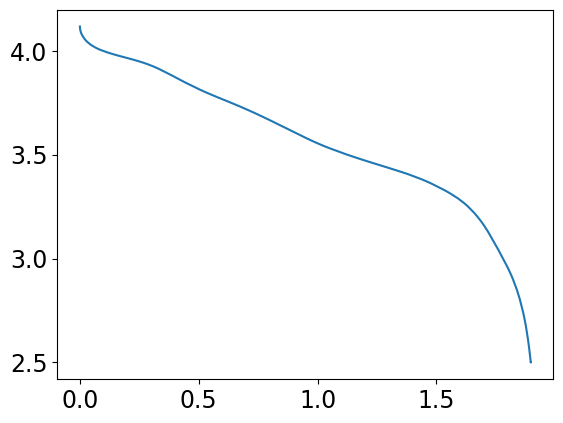

In [57]:
# try to plot experiment data
import pandas as pd
Path_Data  = Path_Data_pre+"/example_0p5C_discharge.csv"
my_data = pd.read_csv( Path_Data)

t_exp   = (my_data["Time (s)"] - my_data["Time (s)"][0])/3600
cap_dis = (my_data["Charge (mA.h)"] - my_data["Charge (mA.h)"][0])/1e3
V_exp = my_data["Voltage (V)"]
t_exp = np.array(t_exp).tolist()
V_exp = np.array(V_exp).tolist()
plt.plot(t_exp,V_exp)
XY_Exp =[t_exp,V_exp]
#my_data 

In [58]:
pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1

Para_dict_list = []
for combination in combinations:
    para_one = {}
    for para,combination_i in zip(parameter_names,combination):
        para_one[para]  = combination_i
    Para_dict_list.append(para_one)
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 20


In [59]:
# define experiment
V_max = 4.2;        V_min = 2.5; 
exp_AGE_text = [(
    f"Hold at {V_max} V until C/100",
    f"Discharge at C/2 until {V_min}V", 
    f"Charge at 0.3C until {V_max}V",
    ),  ]  
step_AGE_CD =1;   step_AGE_CC =2;   step_AGE_CV =0;
cycle_no = -1; 
exp_RPT_text = None;  
step_0p1C_CD = None;  step_0p1C_CC = None;
step_0p1C_RE = None;  

In [60]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

# Write para - 1st round:
Values_1 = []
head_keys = list(para_one.keys())
head_pre = [
    "Scan No","Y or N",
    "Error %","Punish",
    "Dry out",]

head_pos = [ 
    "exp_AGE_text", "exp_RPT_text",
    "Cap Loss","LLI to LiP",
    "LLI to SEI","LLI to sei-on-cracks",
    "LAM to Neg","LAM to Pos",
    "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final",
    "Error","Details"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
if not os.path.exists(BasicPath +Target):
    os.mkdir(BasicPath +Target);
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)  

Exp_pack =[
    exp_AGE_text,exp_RPT_text,
    step_AGE_CD,step_AGE_CC,step_AGE_CV,
    step_0p1C_CD ,step_0p1C_CC,step_0p1C_RE,
    cycle_no,book_name_xlsx,
    ] 
if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [61]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  flag_RunOneCyc = True
Return_Sol=True;   Check_Small_Time=True;
fs = 13; dpi = 100;
""" midc_merge,Sol_RPT,Sol_AGE = Run_model(
    para_one,BasicPath, XY_Exp, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time ) """
pool_no = 5
if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_model, 
        args=(
            Para_dict_i,BasicPath, XY_Exp, 
            purpose,    Exp_pack, keys_all,dpi,fs,
            flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
            Check_Small_Time ) )
        for Para_dict_i in Para_dict_list]
    Result = [p.get() for p in processes]  

Your own print statement
Start Now! Scan 1.
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 3.
Start Now! Scan 4.
Your own print statement
Start Now! Scan 2.
Start Now! Scan 5.
Scan 1: Spent 38.985 ms on Initialization
Scan 4: Spent 47.292 ms on Initialization
Scan 5: Spent 49.931 ms on Initialization
Scan 3: Spent 58.958 ms on Initialization
Scan 2: Spent 69.930 ms on Initialization


At t = 463.092 and h = 6.15034e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.092 and h = 5.42078e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 336.631 and h = 1.56283e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 264.285 and h = 2.3796e-10, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 1: Finish break-in cycle within 9.677 s
Scan 3: Finish break-in cycle within 9.731 s
Scan 1: Finish post-process for break-in cycle within 878.482 ms
Scan 3: Finish post-process for break-in cycle within 939.803 ms
Scan 4: Finish break-in cycle within 10.783 s
Scan 5: Finish break-in cycle within 11.132 s
Scan 2: Finish break-in cycle within 11.601 s
Scan 1: Finish all plots within 1.224 s


Successfully create a excel file
Scan 1: Successfully save json file!

Scan 4: Finish post-process for break-in cycle within 1.106 s



Scan 1: Try saving within 160.777 ms


Succeed doing something in 12.104 s
This is the end of No. 1 scan
Scan 3: Finish all plots within 1.507 s


Successfully create a excel file
Scan 3: Successfully save json file!
Scan 3: Try saving within 71.235 ms


Succeed doing something in 12.464 s
This is the end of No. 3 scan
Scan 5: Finish post-process for break-in cycle within 1.442 s
Scan 2: Finish post-process for break-in cycle within 1.692 s
Your own print statement
Your own print statement
Start Now! Scan 6.
Start Now! Scan 6.
Scan 6: Spent 80.735 ms on Initialization
Scan 6: Spent 80.735 ms on Initialization
Scan 4: Finish all plots within 2.395 s


Successfully create a excel file
Scan 4: Successfully save json file!
Scan 4: Try saving within 137.626 ms


Succeed doing something in 14.630 s
This is the end of No. 4 scan
Scan 5: Finish all plots within 2.300 s


Successfully create a excel file
Scan 5: Successfully save json file!
Scan 5: Try saving within 149.004 ms


Succeed doing something in 15.201 s
This is the end of No. 5 scan
Scan 2: Finish all plots within 2.293 s


Successfully create a excel file

Your own print statement



Scan 2: Successfully save json file!


Your own print statement


Scan 2: Try saving within 100.477 ms


Start Now! Scan 7.
Start Now! Scan 7.
Succeed doing something in 15.925 s
This is the end of No. 2 scan
Scan 7: Spent 109.618 ms on Initialization
Scan 7: Spent 109.618 ms on Initialization
Your own print statement
Your own print statement
Start Now! Scan 8.
Start Now! Scan 8.
Scan 8: Spent 105.479 ms on Initialization
Scan 8: Spent 105.479 ms on Initialization
Your own print statement
Your own print statement
Start Now! Scan 9.
Start Now! Scan 9.
Scan 9: Spent 122.259 ms on Initialization
Scan 9: Spent 122.259 ms on Initialization
Your own print statement
Your own print statement
Start Now! Scan 10.
Start Now! Scan 10.
Scan 10: Spent 95.903 ms on Initialization
Scan 10: Spent 95.903 ms on Initialization
Scan 6: Finish break-in cycle within 8.547 s
Scan 6: Finish break-in cycle within 8.547 s
Scan 6: Finish post-process for break-in cycle within 781.074 ms
Scan 6: Finish post-process for break-in cycle within 781.074 ms
At t = 534.67 and h = 6.73845e-11, the corrector convergence faile

Successfully create a excel file
Scan 6: Successfully save json file!
Scan 6: Try saving within 111.666 ms


Succeed doing something in 11.201 s
Succeed doing something in 11.201 s
This is the end of No. 6 scan
This is the end of No. 6 scan
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 11.
Start Now! Scan 11.
Start Now! Scan 11.
Scan 11: Spent 146.872 ms on Initialization
Scan 11: Spent 146.872 ms on Initialization
Scan 11: Spent 146.872 ms on Initialization
Scan 7: Finish break-in cycle within 10.723 s
Scan 7: Finish break-in cycle within 10.723 s
Scan 8: Finish break-in cycle within 9.475 s
Scan 8: Finish break-in cycle within 9.475 s
Scan 8: Finish post-process for break-in cycle within 938.763 ms
Scan 8: Finish post-process for break-in cycle within 938.763 ms
Scan 7: Finish post-process for break-in cycle within 1.086 s
Scan 7: Finish post-process for break-in cycle within 1.086 s
Scan 9: Finish break-in cycle within 9.940 s
Scan 9: Finish break-in cycle within 9.940 s
At t = 377.319 and h = 5.8716e-11, the corrector convergence failed repeate

Successfully create a excel file
Successfully create a excel fileScan 7: Successfully save json file!

Scan 8: Successfully save json file!Scan 7: Try saving within 106.372 ms

Scan 8: Try saving within 169.368 ms

Succeed doing something in 13.790 s
Succeed doing something in 13.790 s


This is the end of No. 7 scan
Succeed doing something in 12.468 s
This is the end of No. 7 scan
Succeed doing something in 12.468 s
This is the end of No. 8 scan
This is the end of No. 8 scan
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 12.
Start Now! Scan 12.
Start Now! Scan 12.
Scan 12: Spent 138.516 ms on Initialization
Scan 12: Spent 138.516 ms on Initialization
Scan 12: Spent 138.516 ms on Initialization
Scan 9: Finish all plots within 1.425 s
Scan 9: Finish all plots within 1.425 s


Successfully create a excel file
Scan 9: Successfully save json file!
Scan 9: Try saving within 120.958 ms


Succeed doing something in 12.404 s
Succeed doing something in 12.404 s
This is the end of No. 9 scan
This is the end of No. 9 scan
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 13.
Start Now! Scan 13.
Start Now! Scan 13.
Scan 13: Spent 125.074 ms on Initialization
Scan 10: Finish break-in cycle within 11.240 s
Scan 10: Finish break-in cycle within 11.240 s
Scan 13: Spent 125.074 ms on Initialization
Scan 13: Spent 125.074 ms on Initialization
Scan 10: Finish post-process for break-in cycle within 1.162 s
Scan 10: Finish post-process for break-in cycle within 1.162 s
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 14.
Start Now! Scan 14.
Start Now! Scan 14.
Scan 14: Spent 122.370 ms on Initialization
Scan 14: Spent 122.370 ms on Initialization
Scan 14: Spent 122.370 ms on Initialization
Scan 10: Finish all plots within 1.325 s
Scan 10: Finish all plots within 1.325 s


Successfully create a excel file
Scan 10: Successfully save json file!
Scan 10: Try saving within 164.390 ms


Succeed doing something in 14.189 s
Succeed doing something in 14.189 s
This is the end of No. 10 scan
This is the end of No. 10 scan
At t = 509.946 and h = 1.72766e-09, the corrector convergence failed repeatedly or with |h| = hmin.
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 15.
Start Now! Scan 15.
Start Now! Scan 15.
Scan 15: Spent 141.625 ms on Initialization
Scan 15: Spent 141.625 ms on Initialization
Scan 15: Spent 141.625 ms on Initialization
Scan 11: Finish break-in cycle within 10.432 s
Scan 11: Finish break-in cycle within 10.432 s
Scan 11: Finish break-in cycle within 10.432 s
Scan 11: Finish post-process for break-in cycle within 604.927 ms
Scan 11: Finish post-process for break-in cycle within 604.927 ms
Scan 11: Finish post-process for break-in cycle within 604.927 ms
At t = 275.488 and h = 1.4731e-14, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 11: Finish all plots within 1.001 s
Scan 11: Finish all 

Successfully create a excel file
Scan 11: Successfully save json file!
Scan 11: Try saving within 111.646 ms


Succeed doing something in 12.619 s
Succeed doing something in 12.619 s
Succeed doing something in 12.619 s
This is the end of No. 11 scan
This is the end of No. 11 scan
This is the end of No. 11 scan
At t = 254.99 and h = 2.12954e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 12: Finish break-in cycle within 9.765 s
Scan 12: Finish break-in cycle within 9.765 s
Your own print statement
Scan 12: Finish break-in cycle within 9.765 s
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 16.
Start Now! Scan 16.
Start Now! Scan 16.
Start Now! Scan 16.
Scan 16: Spent 182.326 ms on Initialization
Scan 16: Spent 182.326 ms on Initialization
Scan 16: Spent 182.326 ms on Initialization
Scan 16: Spent 182.326 ms on Initialization
Scan 12: Finish post-process for break-in cycle within 769.973 ms
Scan 12: Finish post-process for break-in cycle within 769.973 ms
Scan 12: Finish post-process for break-in cycle within 769.973 ms
Scan 13:

Successfully create a excel file
Scan 12: Successfully save json file!
Scan 12: Try saving within 44.258 ms


Succeed doing something in 12.050 s
Scan 14: Finish break-in cycle within 9.243 s
Scan 14: Finish break-in cycle within 9.243 s
Scan 14: Finish break-in cycle within 9.243 s
Succeed doing something in 12.050 s
Succeed doing something in 12.050 s
This is the end of No. 12 scan
This is the end of No. 12 scan
This is the end of No. 12 scan
Scan 13: Finish post-process for break-in cycle within 804.480 ms
Scan 13: Finish post-process for break-in cycle within 804.480 ms
Scan 13: Finish post-process for break-in cycle within 804.480 ms
At t = 367.148 and h = 8.26575e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 14: Finish post-process for break-in cycle within 704.754 ms
Scan 14: Finish post-process for break-in cycle within 704.754 ms
Scan 14: Finish post-process for break-in cycle within 704.754 ms
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 17.
Start Now! Scan 17.
Start Now! Scan 17.
Start

Successfully create a excel file
Scan 13: Successfully save json file!
Scan 13: Try saving within 97.615 ms


Succeed doing something in 12.795 s
Succeed doing something in 12.795 s
Succeed doing something in 12.795 s
This is the end of No. 13 scan
This is the end of No. 13 scan
This is the end of No. 13 scan
Scan 15: Finish break-in cycle within 9.164 s
Scan 15: Finish break-in cycle within 9.164 s
Scan 15: Finish break-in cycle within 9.164 s
Scan 14: Finish all plots within 1.539 s
Scan 14: Finish all plots within 1.539 s
Scan 14: Finish all plots within 1.539 s


Successfully create a excel file
Scan 14: Successfully save json file!
Scan 14: Try saving within 148.439 ms


Succeed doing something in 11.969 s
Succeed doing something in 11.969 s
Succeed doing something in 11.969 s
This is the end of No. 14 scan
This is the end of No. 14 scan
This is the end of No. 14 scan
Scan 15: Finish post-process for break-in cycle within 635.341 ms
Scan 15: Finish post-process for break-in cycle within 635.341 ms
Scan 15: Finish post-process for break-in cycle within 635.341 ms
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 18.
Start Now! Scan 18.
Start Now! Scan 18.
Start Now! Scan 18.
Scan 18: Spent 244.244 ms on Initialization
Scan 18: Spent 244.244 ms on Initialization
Scan 18: Spent 244.244 ms on Initialization
Scan 18: Spent 244.244 ms on Initialization
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 19.
Start Now! Scan 19.
Start Now! Scan 19.
Start Now! Scan 19.
Scan 15: Finish all plots within 1.283 s
Scan 19: Spent 188.223 m

Successfully create a excel file
Scan 15: Successfully save json file!
Scan 15: Try saving within 117.101 ms


Succeed doing something in 11.612 s
Succeed doing something in 11.612 s
Succeed doing something in 11.612 s
This is the end of No. 15 scan
This is the end of No. 15 scan
This is the end of No. 15 scan
Scan 16: Finish break-in cycle within 8.005 s
Scan 16: Finish break-in cycle within 8.005 s
Scan 16: Finish break-in cycle within 8.005 s
Scan 16: Finish break-in cycle within 8.005 s
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 20.
Start Now! Scan 20.
At t = 234.681 and h = 2.63121e-14, the corrector convergence failed repeatedly or with |h| = hmin.Start Now! Scan 20.
Start Now! Scan 20.

Scan 20: Spent 189.959 ms on Initialization
Scan 20: Spent 189.959 ms on Initialization
Scan 20: Spent 189.959 ms on Initialization
Scan 20: Spent 189.959 ms on Initialization
At t = 234.687 and h = 7.82332e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 16: Finish post-process for break-in cycle within 864.

Successfully create a excel file
Scan 16: Successfully save json file!
Scan 16: Try saving within 103.590 ms


Succeed doing something in 10.593 s
Succeed doing something in 10.593 s
Succeed doing something in 10.593 s
Succeed doing something in 10.593 s
This is the end of No. 16 scan
This is the end of No. 16 scan
This is the end of No. 16 scan
This is the end of No. 16 scan
At t = 483.458 and h = 7.93957e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 17: Finish break-in cycle within 7.835 s
Scan 17: Finish break-in cycle within 7.835 s
Scan 17: Finish break-in cycle within 7.835 s
Scan 17: Finish break-in cycle within 7.835 s
Scan 17: Finish post-process for break-in cycle within 869.173 ms
Scan 17: Finish post-process for break-in cycle within 869.173 ms
Scan 17: Finish post-process for break-in cycle within 869.173 ms
Scan 17: Finish post-process for break-in cycle within 869.173 ms
Scan 18: Finish break-in cycle within 7.348 s
Scan 18: Finish break-in cycle within 7.348 s
Scan 18: Finish break-in cycle within 7.348 s
Scan 18: Finish break-in cycle within 7.348 s


Successfully create a excel file
Scan 17: Successfully save json file!
Scan 17: Try saving within 84.172 ms


Succeed doing something in 10.356 s
Succeed doing something in 10.356 s
Succeed doing something in 10.356 s
Succeed doing something in 10.356 s
This is the end of No. 17 scan
This is the end of No. 17 scan
This is the end of No. 17 scan
This is the end of No. 17 scan
Scan 18: Finish post-process for break-in cycle within 692.124 ms
Scan 18: Finish post-process for break-in cycle within 692.124 ms
Scan 18: Finish post-process for break-in cycle within 692.124 ms
Scan 18: Finish post-process for break-in cycle within 692.124 ms
At t = 331.441 and h = 4.38854e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 19: Finish break-in cycle within 8.157 s
Scan 19: Finish break-in cycle within 8.157 s
Scan 19: Finish break-in cycle within 8.157 s
Scan 19: Finish break-in cycle within 8.157 s
Scan 18: Finish all plots within 1.138 s
Scan 18: Finish all plots within 1.138 s
Scan 18: Finish all plots within 1.138 s
Scan 18: Finish all plots within 1.138 s


Successfully create a excel file
Scan 18: Successfully save json file!
Scan 18: Try saving within 24.940 ms


Succeed doing something in 9.709 s
Succeed doing something in 9.709 s
Succeed doing something in 9.709 s
Succeed doing something in 9.709 s
This is the end of No. 18 scan
This is the end of No. 18 scan
This is the end of No. 18 scan
This is the end of No. 18 scan
Scan 19: Finish post-process for break-in cycle within 547.378 ms
Scan 19: Finish post-process for break-in cycle within 547.378 ms
Scan 19: Finish post-process for break-in cycle within 547.378 ms
Scan 19: Finish post-process for break-in cycle within 547.378 ms
Scan 20: Finish break-in cycle within 7.040 s
Scan 20: Finish break-in cycle within 7.040 s
Scan 20: Finish break-in cycle within 7.040 s
Scan 20: Finish break-in cycle within 7.040 s
Scan 19: Finish all plots within 919.712 ms
Scan 19: Finish all plots within 919.712 ms
Scan 19: Finish all plots within 919.712 ms
Scan 19: Finish all plots within 919.712 ms


Successfully create a excel file
Scan 19: Successfully save json file!
Scan 19: Try saving within 65.434 ms


Succeed doing something in 10.123 s
Succeed doing something in 10.123 s
Succeed doing something in 10.123 s
Succeed doing something in 10.123 s
This is the end of No. 19 scan
This is the end of No. 19 scan
This is the end of No. 19 scan
This is the end of No. 19 scan
Scan 20: Finish post-process for break-in cycle within 561.708 ms
Scan 20: Finish post-process for break-in cycle within 561.708 ms
Scan 20: Finish post-process for break-in cycle within 561.708 ms
Scan 20: Finish post-process for break-in cycle within 561.708 ms
Scan 20: Finish all plots within 863.210 ms
Scan 20: Finish all plots within 863.210 ms
Scan 20: Finish all plots within 863.210 ms
Scan 20: Finish all plots within 863.210 ms


Successfully create a excel file
Scan 20: Successfully save json file!
Scan 20: Try saving within 15.341 ms


Succeed doing something in 8.815 s
Succeed doing something in 8.815 s
Succeed doing something in 8.815 s
Succeed doing something in 8.815 s
This is the end of No. 20 scan
This is the end of No. 20 scan
This is the end of No. 20 scan
This is the end of No. 20 scan


In [62]:
Result[0]

({'x [m]': [8.52e-06,
   2.556e-05,
   4.26e-05,
   5.964e-05,
   7.668e-05,
   8.64e-05,
   8.88e-05,
   9.12e-05,
   9.36e-05,
   9.6e-05,
   0.00010476,
   0.00011988000000000001,
   0.00013500000000000003,
   0.00015012,
   0.00016523999999999998],
  'x_n [m]': [8.52e-06, 2.556e-05, 4.26e-05, 5.964e-05, 7.668e-05],
  'x_s [m]': [8.64e-05, 8.88e-05, 9.12e-05, 9.36e-05, 9.6e-05],
  'x_p [m]': [0.00010476,
   0.00011988000000000001,
   0.00013500000000000003,
   0.00015012,
   0.00016523999999999998],
  'CCend Porosity': [[0.21547841352104877,
    0.2154644647078167,
    0.21543415122443607,
    0.21538172611597056,
    0.2152954512559662,
    0.47,
    0.47,
    0.47,
    0.47,
    0.47,
    0.335,
    0.335,
    0.335,
    0.335,
    0.335]],
  'CCend Negative electrode interfacial current density [A.m-2]': [[-0.4024835344678719,
    -0.41483016156118846,
    -0.4385560819090929,
    -0.46999389074224723,
    -0.497576138324159]],
  'CCend Electrolyte potential [V]': [[-0.0541210179

In [63]:
Index_List_succeed = np.arange(1,len(Para_dict_list)+1)
for k,index_i in enumerate(Index_List_succeed):
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = table_tar.max_row # ncolumns_old + k +1 # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 



Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
Successfuly write results for Scan 3!
Successfuly write results for Scan 4!
Successfuly write results for Scan 5!
Successfuly write results for Scan 6!
Successfuly write results for Scan 7!
Successfuly write results for Scan 8!
Successfuly write results for Scan 9!
Successfuly write results for Scan 10!
Successfuly write results for Scan 11!


Successfuly write results for Scan 12!
Successfuly write results for Scan 13!
Successfuly write results for Scan 14!
Successfuly write results for Scan 15!
Successfuly write results for Scan 16!
Successfuly write results for Scan 17!
Successfuly write results for Scan 18!
Successfuly write results for Scan 19!
Successfuly write results for Scan 20!
